# Reading in the dataframe

In [164]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import krippendorff
import imgkit

from sklearn.metrics import classification_report

sample = 'Set-2' #Or Set-2
if sample == 'Set-1':
    file = '/home/pc/Uni/MasterThesis/Scripts/Corpus_abort_sample_chunked_annotated.csv'
    file2 = '/home/pc/Uni/MasterThesis/Scripts/Corpus_econ_sample_chunked_annotated.csv'

elif sample == 'Set-2':
    file = '/home/pc/Uni/MasterThesis/Scripts/Corpus_abortion_sample2_chunked_annotated.csv'
    file2 = '/home/pc/Uni/MasterThesis/Scripts/Corpus_econ_sample2_chunked_annotated.csv'

Corpus_abortion_sample_chunked_annotated_cleaned = pd.read_csv(file)
Corpus_abortion_sample_chunked_annotated_cleaned['expert'] = Corpus_abortion_sample_chunked_annotated_cleaned['expert'].astype(float).astype('int')

Corpus_econ_sample_chunked_annotated_cleaned = pd.read_csv(file2)
Corpus_econ_sample_chunked_annotated_cleaned['expert'] = Corpus_econ_sample_chunked_annotated_cleaned['expert'].astype(float).astype('int')

del file, file2


## Standardizing dataframes

In [165]:
Column_ordering = ['chunk', 'speaker', 'file_name', 'date', 'expert', 'student assistant', 'phi:2.7b', 'gemma3:4b', 'qwen2.5:7b', 'mistral:7b', 'llama3.2:latest', 'stablelm2:12b'] #Standard ordering since the first round of annotations was not standardized
Corpus_econ_sample_chunked_annotated_cleaned = Corpus_econ_sample_chunked_annotated_cleaned.reindex(columns=Column_ordering)
Corpus_abortion_sample_chunked_annotated_cleaned = Corpus_abortion_sample_chunked_annotated_cleaned.reindex(columns=Column_ordering)

if Corpus_abortion_sample_chunked_annotated_cleaned['student assistant'].hasnans:                                   #Exclude student assistant as the column is only featured in the first set of samples
    Corpus_abortion_sample_chunked_annotated_cleaned.drop(columns=['student assistant'], inplace=True)
if Corpus_econ_sample_chunked_annotated_cleaned['student assistant'].hasnans:
    Corpus_econ_sample_chunked_annotated_cleaned.drop(columns=['student assistant'], inplace=True)

if 'Column_ordering' in locals():
    del Column_ordering

# Evaluating metrics

## Speed metrics

In [166]:
performance_econ_df = pd.read_csv('Model_metrics_econ_sample.csv')
performance_econ_df = performance_econ_df.sort_values(by='Speed', ascending=False)
performance_econ_df = performance_econ_df.reset_index(drop=True)

performance_econ_df['Speed'] = performance_econ_df['Speed'] / performance_econ_df['Speed'].max() #Standardizing the speed metric by the fastest model
print(performance_econ_df[['Model', 'Speed']])

             Model     Speed
0         phi:2.7b  1.000000
1  llama3.2:latest  0.988633
2        gemma3:4b  0.951229
3       qwen2.5:7b  0.891019
4       mistral:7b  0.839343
5    stablelm2:12b  0.752199


In [167]:
performance_abortion_df = pd.read_csv('Model_metrics_abortion_sample.csv')
performance_abortion_df = performance_abortion_df.sort_values(by='Speed', ascending=False)
performance_abortion_df = performance_abortion_df.reset_index(drop=True)

performance_abortion_df['Speed'] = performance_abortion_df['Speed'] / performance_abortion_df['Speed'].max()
print(performance_abortion_df[['Model', 'Speed']])

             Model     Speed
0         phi:2.7b  1.000000
1  llama3.2:latest  0.976086
2        gemma3:4b  0.942400
3       mistral:7b  0.877817
4       qwen2.5:7b  0.865682
5    stablelm2:12b  0.784476


In [168]:
def model_quality_metrics(sample):
    report = pd.DataFrame(columns=['Model', 'Scores'])

    for model_name in sample.columns[5:]:
        print(f'Model: {model_name}')
        sample[model_name] = sample[model_name].astype(int)
        print(classification_report(sample['expert'], sample[model_name], labels=[1, 0], target_names=['Topic mentioned', 'No mentions'], zero_division=np.nan))

        report.loc[len(report)] = {'Model': model_name, 'Scores': classification_report(sample['expert'], sample[model_name], output_dict=True, zero_division=np.nan)}

    return report   

Report_abortion_classification = model_quality_metrics(Corpus_abortion_sample_chunked_annotated_cleaned)
Report_economic_classification = model_quality_metrics(Corpus_econ_sample_chunked_annotated_cleaned)

Model: phi:2.7b
                 precision    recall  f1-score   support

Topic mentioned       0.21      0.64      0.31        22
    No mentions       0.71      0.27      0.39        74

       accuracy                           0.35        96
      macro avg       0.46      0.45      0.35        96
   weighted avg       0.60      0.35      0.37        96

Model: gemma3:4b
                 precision    recall  f1-score   support

Topic mentioned       0.37      1.00      0.54        22
    No mentions       1.00      0.50      0.67        74

       accuracy                           0.61        96
      macro avg       0.69      0.75      0.60        96
   weighted avg       0.86      0.61      0.64        96

Model: qwen2.5:7b
                 precision    recall  f1-score   support

Topic mentioned       0.95      0.91      0.93        22
    No mentions       0.97      0.99      0.98        74

       accuracy                           0.97        96
      macro avg       0.96   

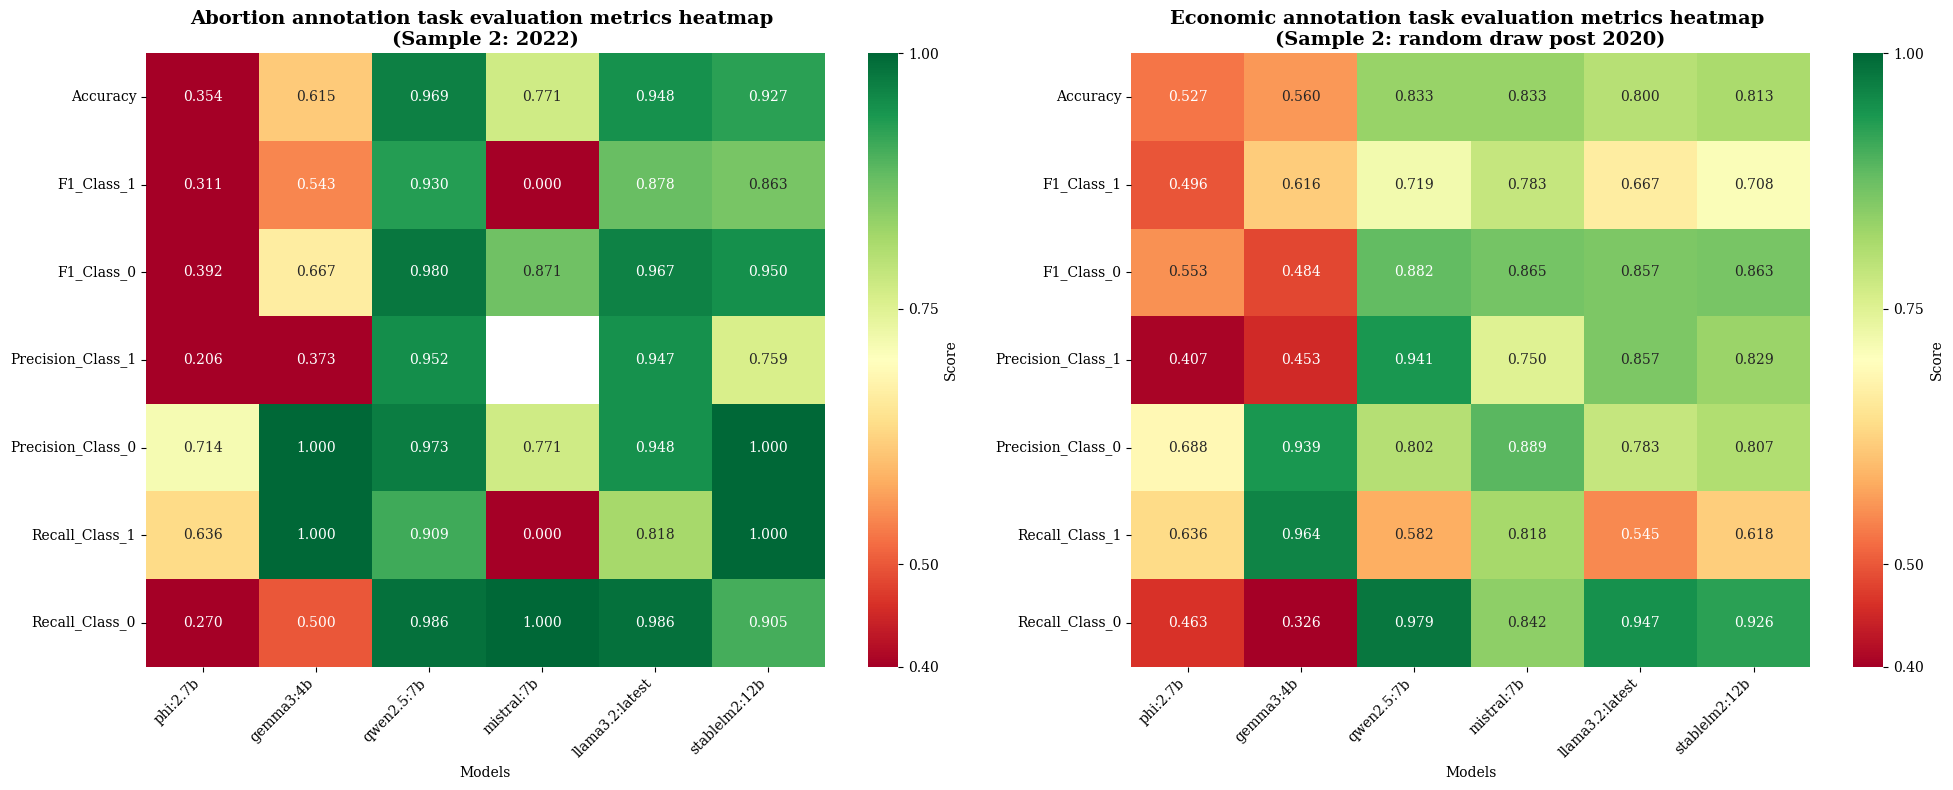

In [169]:
def create_classification_heatmaps(report_abortion, report_economic, sample):
    import seaborn as sns
    import numpy as np

    def extract_metrics(report_df, corpus_name):
        metrics_data = []
        for _, row in report_df.iterrows():
            model_name = row['Model']
            scores = row['Scores']
            
            metrics_data.append({
                'Model': model_name,
                'Accuracy': scores['accuracy'],
                'F1_Class_1': scores['1']['f1-score'],
                'F1_Class_0': scores['0']['f1-score'],
                'Precision_Class_1': scores['1']['precision'],
                'Recall_Class_1': scores['1']['recall'],
                'Precision_Class_0': scores['0']['precision'],
                'Recall_Class_0': scores['0']['recall']
            })
        return pd.DataFrame(metrics_data)
    
    if sample == 'Set-1':
        sample_desc = 'Abortion annotation task evaluation metrics heatmap \n(Sample 1: 1974)'
        sample_desc2 = 'Economic annotation task evaluation metrics heatmap \n(Sample 1: random draw)'
    elif sample == 'Set-2':
        sample_desc = 'Abortion annotation task evaluation metrics heatmap \n(Sample 2: 2022)'
        sample_desc2 = 'Economic annotation task evaluation metrics heatmap \n(Sample 2: random draw post 2020)'
    
    abortion_metrics = extract_metrics(report_abortion, 'Abortion annotation task')
    economic_metrics = extract_metrics(report_economic, 'Economic annotation task')
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Abortion heatmap
    abortion_heatmap_data = abortion_metrics.set_index('Model')[['Accuracy', 'F1_Class_1', 'F1_Class_0', 'Precision_Class_1', 'Precision_Class_0', 'Recall_Class_1', 'Recall_Class_0']]
    abortion_hm = sns.heatmap(
                abortion_heatmap_data.T, annot=True, cmap='RdYlGn', fmt='.3f', 
                cbar_kws={'label': 'Score'}, ax=axes[0], 
                annot_kws={'size': 10, 'family':'DejaVu Serif'},
                vmin=0.4, vmax=1
                )
    cbar0 = abortion_hm.collections[0].colorbar
    cbar0.ax.yaxis.label.set_fontproperties('DejaVu Serif')
    cbar0.ax.yaxis.label.set_size(10)
    cbar0.set_ticks([0.4, 0.5, 0.75, 1])
    for label in cbar0.ax.get_yticklabels():
        label.set_fontname('DejaVu Serif')
        label.set_fontsize(10)
    axes[0].set_title(sample_desc, fontsize=14, fontweight='bold', family='DejaVu Serif')
    axes[0].set_xlabel('Models', fontsize=10, family='DejaVu Serif')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right', family='DejaVu Serif', fontsize=10)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, family='DejaVu Serif', fontsize=10)

    # Economic heatmap
    economic_heatmap_data = economic_metrics.set_index('Model')[['Accuracy', 'F1_Class_1', 'F1_Class_0', 'Precision_Class_1', 'Precision_Class_0', 'Recall_Class_1', 'Recall_Class_0']]
    economic_hm = sns.heatmap(
        economic_heatmap_data.T, annot=True, cmap='RdYlGn', fmt='.3f',
        cbar_kws={'label': 'Score'}, ax=axes[1],
        annot_kws={'size': 10, 'family':'DejaVu Serif'},
        vmin=0.4, vmax=1
    )
    cbar1 = economic_hm.collections[0].colorbar
    cbar1.ax.yaxis.label.set_fontproperties('DejaVu Serif')
    cbar1.ax.yaxis.label.set_size(10)
    cbar1.set_ticks([0.4, 0.5, 0.75, 1])
    for label in cbar1.ax.get_yticklabels():
        label.set_fontname('DejaVu Serif')
        label.set_fontsize(10)
    axes[1].set_title(sample_desc2, fontsize=14, fontweight='bold', family='DejaVu Serif')
    axes[1].set_xlabel('Models', fontsize=10, family='DejaVu Serif')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right', family='DejaVu Serif', fontsize=10)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, family='DejaVu Serif', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'classification_metrics_heatmaps_{sample}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return abortion_metrics, economic_metrics

abortion_data, economic_data = create_classification_heatmaps(Report_abortion_classification, Report_economic_classification, sample)

## Mean F1 scores for diachronic comparison

In [170]:
macrodata_df = pd.read_csv('Model_classification_metrics_macrodata_full.csv') #if the dataframe has previously been created


In [171]:
print(f'Mean F1 score for all models and classes for the abortion annotation task: {round((abortion_data['F1_Class_1'].mean()+abortion_data['F1_Class_0'].mean())/2,ndigits=3)}')
print(f'Mean F1 score for all models and classes for the economic annotation task: {round((economic_data['F1_Class_1'].mean()+economic_data['F1_Class_0'].mean())/2,ndigits=3)}')

#macrodata_df = pd.DataFrame(columns=['Task', 'sample', 'model', 'F1_0', 'F1_1', 'Mean_F1', 'Accuracy', 'Precision_0', 'Precision_1', 'Recall_0', 'Recall_1']) #if the dataframe has not been created
macrodata_df = pd.concat([macrodata_df, pd.DataFrame({
    'Task': ['Abortion'] * len(abortion_data),
    'sample': [sample] * len(abortion_data),
    'model' : abortion_data['Model'],
    'F1_0': abortion_data['F1_Class_0'],
    'F1_1': abortion_data['F1_Class_1'],
    'Mean_F1': (abortion_data['F1_Class_0'] + abortion_data['F1_Class_1']) / 2,
    'Accuracy': abortion_data['Accuracy'],
    'Precision_0': abortion_data['Precision_Class_0'],
    'Precision_1': abortion_data['Precision_Class_1'],
    'Recall_0': abortion_data['Recall_Class_0'],
    'Recall_1': abortion_data['Recall_Class_1']
})], ignore_index=True)

macrodata_df = pd.concat([macrodata_df, pd.DataFrame({
    'Task': ['Economic'] * len(economic_data),
    'sample': [sample] * len(economic_data),
    'model' : economic_data['Model'],
    'F1_0': economic_data['F1_Class_0'],
    'F1_1': economic_data['F1_Class_1'],
    'Mean_F1': (economic_data['F1_Class_0'] + economic_data ['F1_Class_1']) / 2,
    'Accuracy': economic_data['Accuracy'],
    'Precision_0': economic_data['Precision_Class_0'],
    'Precision_1': economic_data['Precision_Class_1'],
    'Recall_0': economic_data['Recall_Class_0'],
    'Recall_1': economic_data['Recall_Class_1']
})], ignore_index=True)

#macrodata_df.to_csv('Model_classification_metrics_macrodata_full.csv', index=False)

Mean F1 score for all models and classes for the abortion annotation task: 0.696
Mean F1 score for all models and classes for the economic annotation task: 0.708


In [172]:
import seaborn as sns

macrodata_df_sel = macrodata_df.drop(macrodata_df[macrodata_df['model'] == 'student assistant'].index) #Only the first set of samples contains the student assistant annotations additional to the gold standard
macrodata_pivot = macrodata_df_sel.pivot_table(
    index=['Task', 'model'],
    columns='sample',
    values=['F1_0', 'F1_1', 'Mean_F1', 'Accuracy', 'Precision_0', 'Precision_1', 'Recall_0', 'Recall_1']
)

diff = macrodata_pivot.xs('Set-2', level=1, axis=1) - macrodata_pivot.xs('Set-1', level=1, axis=1)
diff.columns = [f"{col}_diff" for col in diff.columns]

# Concatenate Set-1, Set-2, and difference for display
comparison_table = pd.concat([
    macrodata_pivot.xs('Set-1', level=1, axis=1).add_suffix('_Set-1'),
    macrodata_pivot.xs('Set-2', level=1, axis=1).add_suffix('_Set-2'),
    diff
], axis=1)

comparison_table = comparison_table.reset_index()
comparison_table = comparison_table[['Task', 'model', 'Accuracy_diff', 'Mean_F1_diff', 'Precision_0_diff', 'Precision_1_diff', 'Recall_0_diff', 'Recall_1_diff']] 

def highlight_negative(val):
    color = 'red' if isinstance(val, (int, float)) and val < 0 else ''
    return f'color: {color}'

styled_table = comparison_table.style.format({
    'Accuracy_diff': '{:.3f}', 'Mean_F1_diff': '{:.3f}', 'Precision_0_diff': '{:.3f}', 'Precision_1_diff': '{:.3f}', 'Recall_0_diff': '{:.3f}', 'Recall_1_diff': '{:.3f}'
}).applymap(highlight_negative, subset=['Accuracy_diff', 'Mean_F1_diff', 'Precision_0_diff', 'Precision_1_diff', 'Recall_0_diff', 'Recall_1_diff'])
styled_table

styled_table.to_html('styled_table.html')


/tmp/ipykernel_111312/378066049.py:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(highlight_negative, subset=['Accuracy_diff', 'Mean_F1_diff', 'Precision_0_diff', 'Precision_1_diff', 'Recall_0_diff', 'Recall_1_diff'])


# Plotting differences

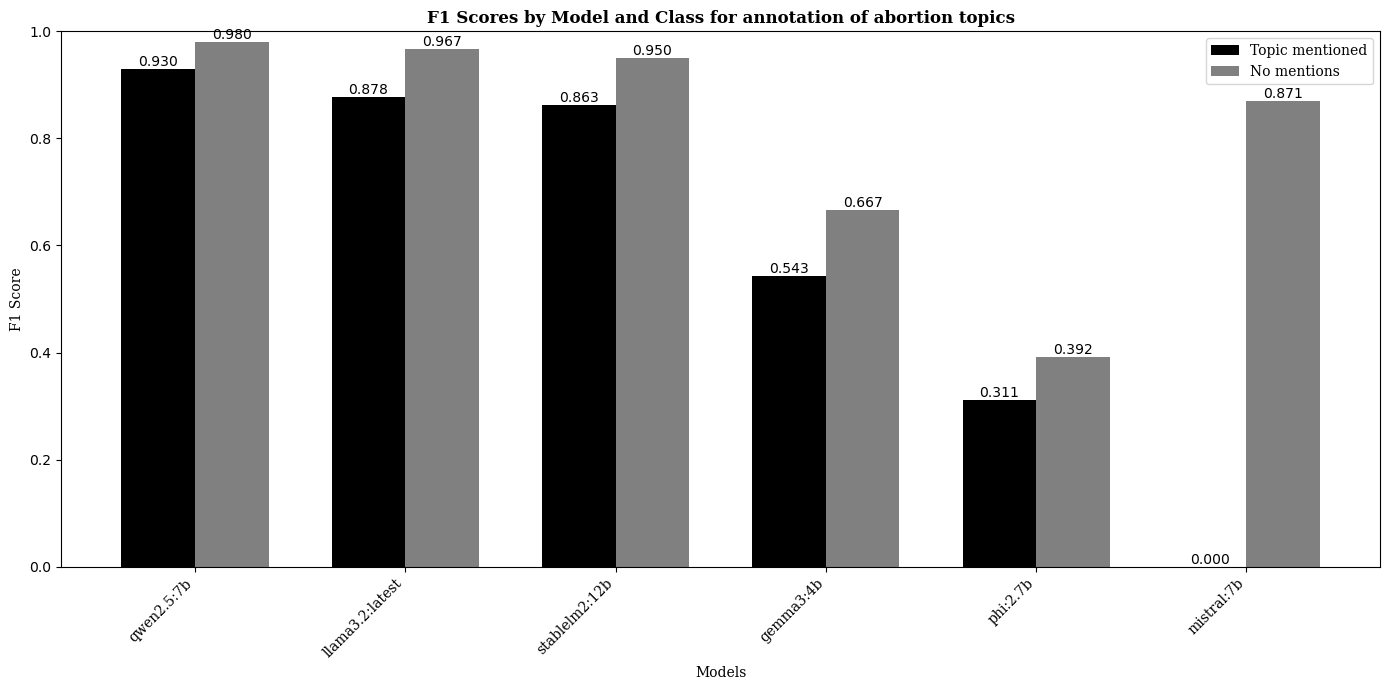

In [173]:
f1_scored_abort_df = pd.DataFrame(columns=['Model', 'F1_0', 'F1_1'])

for model_name in Corpus_abortion_sample_chunked_annotated_cleaned.columns[5:12]:

    Corpus_abortion_sample_chunked_annotated_cleaned[model_name] = Corpus_abortion_sample_chunked_annotated_cleaned[model_name].astype(int)
    report = classification_report(
        Corpus_abortion_sample_chunked_annotated_cleaned['expert'], 
        Corpus_abortion_sample_chunked_annotated_cleaned[model_name], 
        output_dict=True,
        zero_division=np.nan
    )

    f1_scored_abort_df.loc[len(f1_scored_abort_df)] = {'Model': model_name, 'F1_0': report['0']['f1-score'], 'F1_1': report['1']['f1-score']}

f1_scored_abort_df = f1_scored_abort_df.sort_values(by='F1_1', ascending=False).reset_index().drop(columns=['index'])

plt.figure(figsize=(14, 7))

bar_width = 0.35
x = np.arange(len(f1_scored_abort_df['Model']))

bar1 = plt.bar(x - bar_width/2, f1_scored_abort_df['F1_1'], width=bar_width, color='black')
bar2 = plt.bar(x + bar_width/2, f1_scored_abort_df['F1_0'], width=bar_width, color='grey')

plt.ylabel('F1 Score', fontsize=10, family='DejaVu Serif')
plt.bar_label(bar1, fontsize=10, fmt='%.3f')
plt.bar_label(bar2, fontsize=10, fmt='%.3f')
plt.title('F1 Scores by Model and Class for annotation of abortion topics', fontsize=12, fontweight='bold', family='DejaVu Serif')
plt.xlabel('Models', fontsize=10, family='DejaVu Serif')
plt.xticks(x, f1_scored_abort_df['Model'], rotation=45, ha='right', fontname='DejaVu Serif', fontsize=10)
plt.legend([bar1, bar2], ['Topic mentioned', 'No mentions'], prop={'family': 'DejaVu Serif', 'size':10})
plt.yticks(fontsize=10)
plt.ylim(0, 1)

plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.show()

del bar1, bar2, x, bar_width, report, model_name #Saving RAM saves lives. 

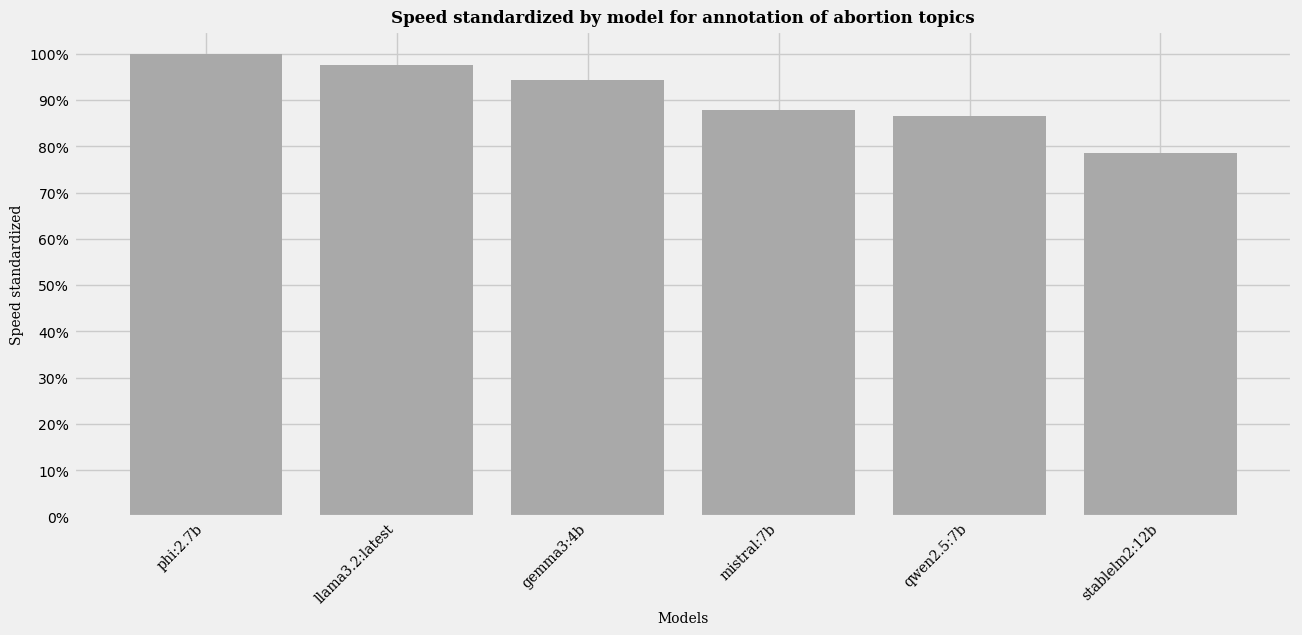

In [174]:
plt.figure(figsize=(14, 6))
plt.bar(performance_abortion_df['Model'], height=performance_abortion_df['Speed'], color = 'darkgrey')
plt.xlabel('Models', fontsize=10, family='DejaVu Serif')
plt.ylabel('Speed standardized', fontsize=10, family='DejaVu Serif')
plt.title('Speed standardized by model for annotation of abortion topics', fontsize=12, fontweight='bold', family='DejaVu Serif')
plt.xticks(rotation=45, ha='right', fontname='DejaVu Serif', fontsize = 10)
plt.yticks(np.arange(0, 1.1, 0.1), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], fontsize=10)
plt.style.use('fivethirtyeight')
plt.savefig('abortion_annotation_speed.png', dpi=300, bbox_inches='tight')
plt.show()

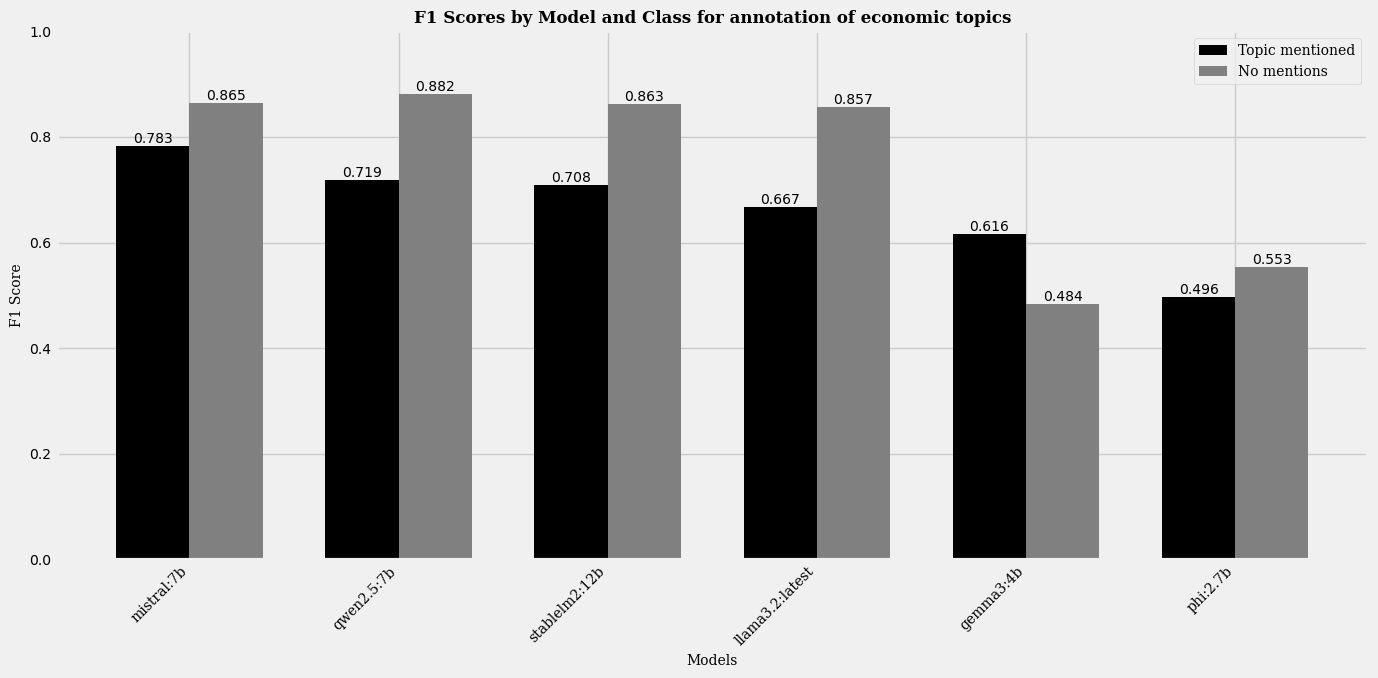

In [175]:
f1_scored_econ_df = pd.DataFrame(columns=['Model', 'F1_0', 'F1_1'])

for model_name in Corpus_econ_sample_chunked_annotated_cleaned.columns[5:12]:
    report = classification_report(
        Corpus_econ_sample_chunked_annotated_cleaned['expert'], 
        Corpus_econ_sample_chunked_annotated_cleaned[model_name], 
        output_dict=True
    )

    f1_scored_econ_df.loc[len(f1_scored_econ_df)] = {'Model': model_name, 'F1_0': report['0']['f1-score'], 'F1_1': report['1']['f1-score']}
    
f1_scored_econ_df = f1_scored_econ_df.sort_values(by='F1_1', ascending=False).reset_index().drop(columns=['index'])

plt.figure(figsize=(14, 7))

bar_width = 0.35
x = np.arange(len(f1_scored_econ_df['Model']))

bar1 = plt.bar(x - bar_width/2, f1_scored_econ_df['F1_1'], width=bar_width, color='black')
bar2 = plt.bar(x + bar_width/2, f1_scored_econ_df['F1_0'], width=bar_width, color='grey')

plt.ylabel('F1 Score', fontsize=10, family='DejaVu Serif')
plt.bar_label(bar1, fontsize=10, fmt='%.3f')
plt.bar_label(bar2, fontsize=10, fmt='%.3f')
plt.title('F1 Scores by Model and Class for annotation of economic topics', fontsize=12, fontweight='bold', family='DejaVu Serif')
plt.xlabel('Models', fontsize=10, family='DejaVu Serif')
plt.xticks(x, f1_scored_econ_df['Model'], rotation=45, ha='right', fontname='DejaVu Serif', fontsize=10)
plt.legend([bar1, bar2], ['Topic mentioned', 'No mentions'], prop={'family': 'DejaVu Serif', 'size':10})
plt.yticks(fontsize=10)
plt.ylim(0, 1)

plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.show()
del bar1, bar2, x, bar_width, report, model_name


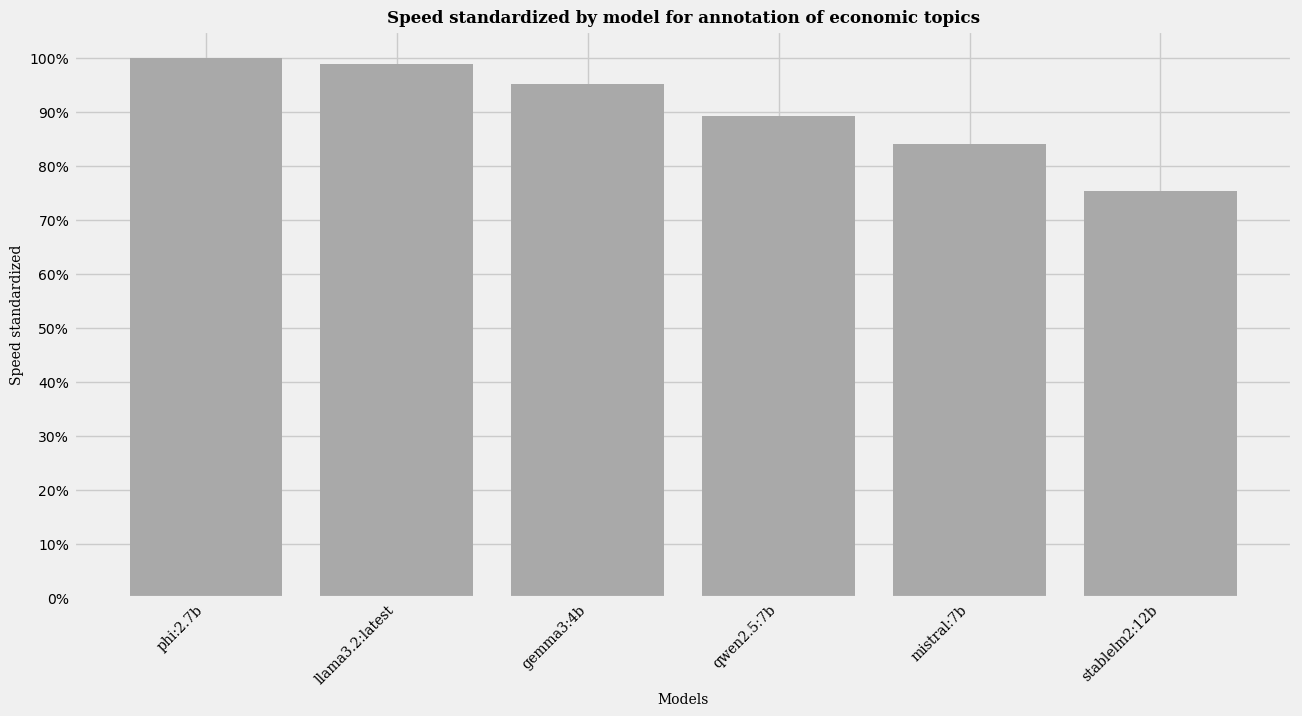

In [176]:
plt.figure(figsize=(14, 7))
plt.bar(performance_econ_df['Model'], height=performance_econ_df['Speed'], color = 'darkgrey')
plt.xlabel('Models', fontsize=10, family='DejaVu Serif')
plt.ylabel('Speed standardized', fontsize=10, family='DejaVu Serif')
plt.yticks(np.arange(0, 1.1, 0.1), ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], fontsize=10)
plt.title('Speed standardized by model for annotation of economic topics', fontsize=12, fontweight='bold', family='DejaVu Serif')
plt.xticks(rotation=45, ha='right', fontname='DejaVu Serif', fontsize=10)
plt.style.use('fivethirtyeight')
plt.savefig('economic_annotation_speed.png', dpi=300, bbox_inches='tight')
plt.show()

## Excluding outlier models

In [177]:
Corpus_abortion_selected = Corpus_abortion_sample_chunked_annotated_cleaned[['qwen2.5:7b','gemma3:4b', 'llama3.2:latest', 'stablelm2:12b','expert']] #removing Phi and Mistral due to especially low performance
Corpus_econ_selected = Corpus_econ_sample_chunked_annotated_cleaned[['gemma3:4b', 'llama3.2:latest', 'stablelm2:12b', 'mistral:7b', 'expert']] #removing Phi and Mistral due to especially low performance


## Calculating intermodel-aggreement

In [178]:
def krippendorff_alpha(corpus1, corpus2):

    annotation_cols_abort = corpus1.columns[~corpus1.columns.isin(['mean_agreement', 'agreement', 'expert', 'student assistent', 'chunk', 'speaker', 'date', 'file_name','processing_type'])]
    annotation_cols_econ = corpus2.columns[~corpus2.columns.isin(['mean_agreement', 'agreement', 'expert', 'student assistent', 'chunk', 'speaker', 'date', 'file_name','processing_type'])]

    data_for_alpha_abort = corpus1[annotation_cols_abort].T.values
    data_for_alpha_econ = corpus2[annotation_cols_econ].T.values

    alpha_abort = krippendorff.alpha(reliability_data=data_for_alpha_abort, level_of_measurement='nominal')
    print(f"Krippendorff's Alpha (Abortion Corpus): {alpha_abort:.3f}")

    alpha_econ = krippendorff.alpha(reliability_data=data_for_alpha_econ, level_of_measurement='nominal')
    print(f"Krippendorff's Alpha (Economic Corpus): {alpha_econ:.3f}")
    
def agreement_score(corpus1, corpus2, sigma=0.166):
    cols_to_average1 = corpus1.columns[~corpus1.columns.isin(['mean_agreement', 'agreement', 'expert', 'student assistent', 'chunk', 'speaker', 'date', 'file_name','processing_type'])]
    cols_to_average2 = corpus2.columns[~corpus2.columns.isin(['mean_agreement', 'agreement', 'expert', 'student assistent', 'chunk', 'speaker', 'date', 'file_name','processing_type'])]
    
    corpus1['mean_agreement'] = corpus1[cols_to_average1].mean(axis=1)
    corpus2['mean_agreement'] = corpus2[cols_to_average2].mean(axis=1)

    def inverted_gaussian(x, mu=0.5, sigma=sigma):
            return 1 - np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    corpus1['agreement'] = corpus1['mean_agreement'].apply(inverted_gaussian)
    corpus2['agreement'] = corpus2['mean_agreement'].apply(inverted_gaussian)


    return corpus1, corpus2

if __name__ == '__main__':
    print('Krippendorff for selected models:\n')
    krippendorff_alpha(Corpus_abortion_selected, Corpus_econ_selected)
    print('\nKrippendorff for all models:\n')
    krippendorff_alpha(Corpus_abortion_sample_chunked_annotated_cleaned, Corpus_econ_sample_chunked_annotated_cleaned)
    
    agreement_score(Corpus_abortion_sample_chunked_annotated_cleaned, Corpus_econ_sample_chunked_annotated_cleaned)
    agreement_score(Corpus_abortion_selected, Corpus_econ_selected)
    
    print(f'\nAgreement metrics for the abortion sample \n{Corpus_abortion_sample_chunked_annotated_cleaned['agreement'].describe()}\n')
    print(f'Agreement metrics for the econ sample \n{Corpus_econ_sample_chunked_annotated_cleaned['agreement'].describe()}\n')
    
    print('Agreement score after removing Phi and Mistral \n')
    print(f'Agreement metrics for the abortion sample w.o. Phi and Mistral\n {Corpus_abortion_selected['agreement'].describe()}\n')
    print(f'Agreement metrics for the econ sample w.o. Phi {Corpus_econ_selected['agreement'].describe()}')


Krippendorff for selected models:

Krippendorff's Alpha (Abortion Corpus): 0.478
Krippendorff's Alpha (Economic Corpus): 0.288

Krippendorff for all models:

Krippendorff's Alpha (Abortion Corpus): 0.151
Krippendorff's Alpha (Economic Corpus): 0.234

Agreement metrics for the abortion sample 
count    96.000000
mean      0.619565
std       0.317230
min       0.000000
25%       0.395905
50%       0.866826
75%       0.866826
max       0.989286
Name: agreement, dtype: float64

Agreement metrics for the econ sample 
count    150.000000
mean       0.620274
std        0.339720
min        0.000000
25%        0.395905
50%        0.866826
75%        0.866826
max        0.989286
Name: agreement, dtype: float64

Agreement score after removing Phi and Mistral 

Agreement metrics for the abortion sample w.o. Phi and Mistral
 count    96.000000
mean      0.796695
std       0.282051
min       0.000000
25%       0.678274
50%       0.989286
75%       0.989286
max       0.989286
Name: agreement, dtype: 

/tmp/ipykernel_111312/72700133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus1['mean_agreement'] = corpus1[cols_to_average1].mean(axis=1)
/tmp/ipykernel_111312/72700133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus2['mean_agreement'] = corpus2[cols_to_average2].mean(axis=1)
/tmp/ipykernel_111312/72700133.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

## Evaluating problematic chunks

In [179]:
print(f'Mean length for problematic chunks (abortion): {Corpus_abortion_sample_chunked_annotated_cleaned[Corpus_abortion_sample_chunked_annotated_cleaned['agreement'] <= 0.5]['chunk'].apply(len).mean().round()} \n')
print(f'Mean length for problematic chunks (economic): {Corpus_econ_sample_chunked_annotated_cleaned[Corpus_econ_sample_chunked_annotated_cleaned['agreement'] <= 0.5]['chunk'].apply(len).mean().round()} \n')

print(f'Mean length non-problematic chunks (abortion): {Corpus_abortion_sample_chunked_annotated_cleaned[Corpus_abortion_sample_chunked_annotated_cleaned['agreement'] > 0.5]['chunk'].apply(len).mean().round()} \n')
print(f'Mean length non-problematic chunks (economic): {Corpus_econ_sample_chunked_annotated_cleaned[Corpus_econ_sample_chunked_annotated_cleaned['agreement'] > 0.5]['chunk'].apply(len).mean().round()} \n')


Mean length for problematic chunks (abortion): 6306.0 

Mean length for problematic chunks (economic): 6227.0 

Mean length non-problematic chunks (abortion): 3737.0 

Mean length non-problematic chunks (economic): 4131.0 

